In [1]:
import os

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import pandas as pd
import ast
def conv(inp):
    return ast.literal_eval(inp)

In [3]:
pairs=pd.read_csv("textreuse.csv")

In [4]:
import pickle

# open a file, where you stored the pickled data
file = open('nodes_dict.obj', 'rb')

nodee = pickle.load(file)

In [5]:
ids=set(pairs["0"])
ids.update(pairs["1"])

In [6]:
graphs=dict()
for f in os.listdir("out/"):
    curr=0
    tens=dict()
    id=f.split(".")[0]
    nodes=pd.read_csv("out/"+f, sep="|")
    tens1=[]
    tens2=[]
    feat=[]
    for n in nodes["node_1"]:
        if n in tens:
            tens1.append(tens[n])
        else:
            tens[n]=curr
            tens1.append(curr)
            try:
                feat.append(nodee[n])
            except:
                feat.append([0]*384)
            curr+=1
    for n in nodes["node_2"]:
        if n in tens:
            tens2.append(tens[n])
        else:
            tens[n]=curr
            tens2.append(curr)
            try:
                feat.append(nodee[n])
            except:
                feat.append([0]*384)
            curr+=1
    g=dgl.graph((tens1,tens2))
    g.ndata["attr"]=torch.FloatTensor(feat)
    graphs[id]=dgl.add_self_loop(g)
    
    

C:\Users\lucia\AppData\Local\Temp\ipykernel_23628\573558180.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:278.)
  g.ndata["attr"]=torch.FloatTensor(feat)


In [7]:
pairs["2"]=pairs["2"].replace(0,-1)

In [8]:
g=[]
for i in range(0,len(pairs)):
    g1=pairs["0"][i]
    g2=pairs["1"][i]
    if g1 in graphs and g2 in graphs:
        g.append((dgl.add_self_loop(graphs[g1]), dgl.add_self_loop(graphs[g2]), pairs["2"][i]))

In [9]:
import random
random.shuffle(g)


In [10]:
dataset = g

In [11]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

num_examples = len(dataset)
num_train = int(num_examples * 0.8)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=10, drop_last=False
)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=10, drop_last=False
)

In [12]:
it = iter(train_dataloader)
batch = next(it)
print(batch)

[Graph(num_nodes=2082, num_edges=6379,
      ndata_schemes={'attr': Scheme(shape=(384,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=2005, num_edges=6171,
      ndata_schemes={'attr': Scheme(shape=(384,), dtype=torch.float32)}
      edata_schemes={}), tensor([ 1, -1, -1, -1,  1,  1, -1,  1, -1,  1])]


In [13]:
from dgl.nn import GraphConv


class GCN(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)
        self.conv3 = GraphConv(h_feats, 100)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        h = self.conv3(g, h)
        g.ndata["h"] = h
        return dgl.mean_nodes(g, "h")

In [14]:
from dgl.nn import GATConv

In [43]:
class GAT(nn.Module):
    def __init__(self, in_feats, h_feats, num_heads):
        super(GAT, self).__init__()
        self.layer1 = GATConv(in_feats, h_feats, num_heads=num_heads, activation=F.relu)
        self.layer2 = GATConv(h_feats * num_heads, h_feats, num_heads=num_heads, activation=F.relu)
        self.layer3 = GATConv(h_feats * num_heads, 100, num_heads=num_heads)

    def forward(self, g, h):
        h = self.layer1(g, h).flatten(1)
        h = self.layer2(g, h).flatten(1)
        h = self.layer3(g, h).mean(1)
        g.ndata["h"] = h
        return dgl.mean_nodes(g, "h")


#model = GAT(384, 500, , num_heads=3)

In [15]:
# Create the model with given dimensions
model = GCN(384, 500)
#model = GAT(384, 500,  num_heads=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
epoch_losses = []

for epoch in range(80):
    epoch_loss = 0
    for batch1, batch2, labels in train_dataloader:
        batch1.to('cuda:0')
        batch2.to('cuda:0')
        emb1 = model(batch1, batch1.ndata["attr"].float())
        emb2 = model(batch2, batch2.ndata["attr"].float())
        cos = nn.CosineEmbeddingLoss(margin=0.5)
        loss = cos(emb1,emb2, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    if epoch%5==0:
        print(epoch)
        print(epoch_loss)
    epoch_losses.append(epoch_loss)
num_correct = 0
num_tests = 0


0
435.52069756761193
5
431.8107164874673
10
362.1798340380192
15
342.3240352421999
20
328.15823068097234
25
315.58432092517614
30
305.6482518836856
35
296.5576142966747
40
286.59989119693637
45
274.24538215994835
50
264.35005539283156
55
256.39838591217995
60
244.46449552569538
65
234.92561929486692
70
227.28794410079718
75
219.14146631211042


In [17]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Total Loss (All Batches)')

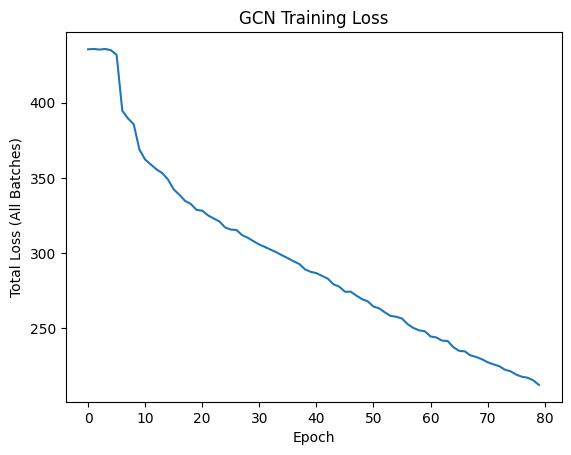

In [18]:
plt.plot(epoch_losses)
plt.title("GCN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Total Loss (All Batches)")

In [19]:
torch.save(model, f="3GCNmodel.torch")

In [20]:
from sklearn.metrics.pairwise import cosine_similarity


ModuleNotFoundError: No module named 'sklearn'

In [21]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

In [22]:
score=[]
lab=[]

In [23]:
from scipy import spatial

In [24]:

score=[]
lab=[]
for batch1, batch2, labels in test_dataloader:
    emb1 = model(batch1, batch1.ndata["attr"].float())
    emb2 = model(batch2, batch2.ndata["attr"].float())
    for i in range(0,10):
        one=emb1[i]
        two=emb2[i]
        label=labels.tolist()[i]
        cos=1-spatial.distance.cosine(one.tolist(), two.tolist())
        score.append(cos)
        lab.append(label)

IndexError: index 8 is out of bounds for dimension 0 with size 8

In [18]:

score=[]
lab=[]
for graph in g:
    try:
        emb1 = model(graph[0], graph[0].ndata["attr"].float())
        emb2 = model(graph[1], graph[1].ndata["attr"].float())
    except:
        continue
    cos=cosine_similarity(emb2.tolist(), emb1.tolist())[0][0]
    #print(cos)
    score.append(cos)
    lab.append(graph[2])

In [25]:
stats=pd.DataFrame([score, lab]).T

In [26]:
stats

,0,1
0,-0.152973,-1.0
1,0.787356,1.0
2,0.430223,-1.0
3,0.861359,1.0
4,-0.048367,1.0
...,...,...
3623,0.695903,-1.0
3624,0.840682,1.0
3625,0.756865,1.0
3626,0.884018,-1.0


In [27]:
stats[stats[1]==1][0].mean()

0.7130120597903274

In [28]:
stats[stats[1]==-1][0].mean()

0.6253561511242705

In [29]:
stats.to_csv("gcn_full.csv")

In [189]:
score[-1]

0.9309332405067987

In [185]:
cosine_similarity(emb2.tolist(), emb1.tolist())[0][0]

0.9945468403917865

In [148]:
for graph in g:
    

In [152]:
pd.DataFrame([lab,score]).T

,0,1
0,1,"[tensor(1.0000, grad_fn=<UnbindBackward0>)]"
1,1,"[tensor(1., grad_fn=<UnbindBackward0>)]"
2,1,"[tensor(1.0000, grad_fn=<UnbindBackward0>)]"
3,1,"[tensor(1.0000, grad_fn=<UnbindBackward0>)]"
4,1,"[tensor(1.0000, grad_fn=<UnbindBackward0>)]"
...,...,...
7434,-1,"[tensor(1., grad_fn=<UnbindBackward0>)]"
7435,-1,"[tensor(1., grad_fn=<UnbindBackward0>)]"
7436,-1,"[tensor(1.0000, grad_fn=<UnbindBackward0>)]"
7437,-1,"[tensor(1., grad_fn=<UnbindBackward0>)]"


In [145]:
pairs["gcn"]=score

ValueError: Length of values (7439) does not match length of index (8909)

In [ ]:
for batch1,batch2, labels in test_dataloader:
    emb1 = model(batch1, batch1.ndata["attr"].float())
    emb2 = model(batch2, batch2.ndata["attr"].float())

print("Test accuracy:", num_correct / num_tests)

In [8]:
pred = model(batched_graph, batched_graph.ndata["attr"].float())

In [12]:
batched_graph.ndata

{'label': tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'attr': tensor([[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

In [10]:
batched_graph.ndata["attr"].float()

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0

In [9]:
pred

tensor([[ 2.4391e-04, -4.3143e-01],
        [ 5.2256e-01, -7.9555e-01],
        [ 1.9058e-01, -5.6637e-01]], grad_fn=<DivBackward0>)